# Лаба №7. Бусаров. 7 вариант

## Предсказание пола клиента по транзакциям 

### Цель работы

В этом задании предлагается ответить на вопрос: возможно ли предсказать пол клиента, используя сведения о поступлениях и тратах по банковской карте? И если возможно, то какая точность такого предсказания?

### Описание

transactions.csv - таблица содержит историю транзакций клиентов банка за один год и три месяца.

customer_id - идентификатор клиента

tr_datetime - день и время совершения транзакции (дни нумеруются с начала данных)

mcc_code - mcc-код транзакции

tr_type - тип транзакции

amount - сумма транзакции в условных единицах; со знаком "+" — начисление средств клиенту (приходная транзакция), "-" — списание средств (расходная транзакция)

term_id - идентификатор терминала

gender_train.csv - таблица содержит информацию по полу для части клиентов, для которых он известен.

customer_id - идентификатор клиента

gender - пол клиента

gender_test_kaggle_sample_submission.csv - пример файла для загрузки решения на Kaggle. Структура таблицы аналогична gender_train.csv

tr_mcc_codes.csv - таблица содержит описание mcc-кодов транзакций.

mcc_code - mcc-код транзакции
mcc_description - описание mcc-кода транзакции
tr_types.csv - таблица содержит описание типов транзакций.

tr_type - тип транзакции
tr_description - описание типа транзакции
gender_pred_sample.csv - пример файла решения.

customer_id - идентификатор клиента
probability - вероятность принадлежности к полу "1"

## Ход работы

In [6]:
!pip install xgboost
import pandas as pd
import numpy as np

import xgboost as xgb
import re
import matplotlib.pyplot as plt

#from tqdm.notebook import tqdm_notebook
from warnings import filterwarnings

%matplotlib inline
filterwarnings('ignore')

Defaulting to user installation because normal site-packages is not writeable


In [7]:
# Считываем данные
tr_mcc_codes = pd.read_csv('./data/tr_mcc_codes.csv', sep=';', index_col='mcc_code')
tr_types = pd.read_csv('./data/tr_types.csv', sep=';', index_col='tr_type')

transactions = pd.read_csv('./data/transactions.csv', index_col='customer_id')
transactions.describe()

gender_train = pd.read_csv('./data/gender_train.csv', index_col='customer_id')
gender_test = pd.DataFrame(columns=['gender'], index = list(set(transactions.index) - set(gender_train.index)))
#gender_test = pd.read_csv('/Users/vane4ka/Desktop/python-and-analyze-data-final-project/gender_test_kaggle_sample_submission.csv', index_col='customer_id')

transactions_train = transactions.join(gender_train, how='inner')
transactions_test = transactions.join(gender_test, how='inner')

In [8]:
print(f'Всего уникальных клиентов: {transactions.index.nunique()}')
print(f'Всего уникальных клиентов с известным полом (train): {transactions_train.index.nunique()}')
print(f'Всего уникальных клиентов с неизвестным полом (test): {transactions_test.index.nunique()}')

Всего уникальных клиентов: 15000
Всего уникальных клиентов с известным полом (train): 8400
Всего уникальных клиентов с неизвестным полом (test): 6600


# Определение пола клиента

In [9]:
# Добавим дополнительные признаки по каждому пользователю в модель.
# Для этого будем анализировать дни недели, часы и состояние дня/ночи.
for df in [transactions_train, transactions_test]:
    df['weekday'] = df['tr_datetime'].str.split().apply(lambda x: int(x[0]) % 7)
    df['hour'] = df['tr_datetime'].apply(lambda x: re.search(' \d*', x).group(0)).astype(int)
    df['isday'] = df['hour'].between(6, 22).astype(int)

transactions_train.sample

def features_creation(x): 
    '''Формирование признаков по каждому пользователю'''
    
    features = []

    # ВременнЫе признаки
    features.append(pd.Series(x['weekday'].value_counts(normalize=True).add_prefix('weekday_')))
    features.append(pd.Series(x['hour'].value_counts(normalize=True).add_prefix('hour_')))
    features.append(pd.Series(x['isday'].value_counts(normalize=True).add_prefix('isday_')))
    
    # Стандартные агрегации, посчитанные на расходах и приходах клиента: 
    # минимум, максимум, среднее, медиана, среднеквадратичное отклонение, количество
    features.append(pd.Series(x[x['amount']>0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('positive_transactions_')))
    features.append(pd.Series(x[x['amount']<0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('negative_transactions_')))

    # Типы транзакций 
    #features.append(pd.Series(x['mcc_code'].value_counts(normalize=True).add_prefix('mcc_code_')))
    # Типы mcc кодов
    #features.append(pd.Series(x['tr_type'].value_counts(normalize=True).add_prefix('tr_type_')))

    # ДОПОЛНИТЕЛЬНЫЕ ПАРАМЕТРЫ
    # ....
    
    return pd.concat(features)

data_train = transactions_train.groupby(transactions_train.index).apply(features_creation).unstack(-1)
data_test = transactions_test.groupby(transactions_test.index).apply(features_creation).unstack(-1)

In [15]:
def cv_score(params, train, y_true):
    '''Cross-validation score (среднее значение метрики ROC AUC на тренировочных данных)'''
    cv_res=xgb.cv(params, xgb.DMatrix(train, y_true),
                  early_stopping_rounds=10, maximize=True, 
                  num_boost_round=10000, nfold=5, stratified=True)
    index_argmax = cv_res['test-auc-mean'].argmax()
    print(f'Cross-validation, ROC AUC: {cv_res.loc[index_argmax]["test-auc-mean"]:.3f}+-{cv_res.loc[index_argmax]["test-auc-std"]:.3f}')
    print(f'Trees: {index_argmax}')
def fit_predict(params, num_trees, train, test, target):
    '''Построение модели + возврат результатов классификации тестовых пользователей'''
    params['learning_rate'] = params['eta']
    clf = xgb.train(params, xgb.DMatrix(train.values, target, feature_names=list(train.columns)), 
                    num_boost_round=num_trees, maximize=True)
    y_pred = clf.predict(xgb.DMatrix(test.values, feature_names=list(train.columns)))
    submission = pd.DataFrame(index=test.index, data=y_pred, columns=['probability'])
    return clf, submission
def draw_feature_importances(clf, top_k=10):
    '''Отрисовка важности переменных. Важность переменной - количество разбиений выборки, 
    в которых участвует данная переменная. Чем больше - тем она, вероятно, лучше 
    '''
    plt.figure(figsize=(10, 10))
    
    importances = dict(sorted(clf.get_score().items(), key=lambda x: x[1])[-top_k:])
    y_pos = np.arange(len(importances))
    
    plt.barh(y_pos, list(importances.values()), align='center', color='green')
    plt.yticks(y_pos, importances.keys(), fontsize=12)
    plt.xticks(fontsize=12)
    plt.xlabel('Feature importance', fontsize=15)
    plt.title('Features importances, Sberbank Gender Prediction', fontsize=18)
    plt.ylim(-0.5, len(importances) - 0.5)
    plt.show()
# Стандартные параметры модели
# !!! Здесь можно и НУЖНО экспериментировать

params = {
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 0.9,
    'colsample_bytree': 0.8,
    
    'gamma': 0,
    'lambda': 0.1,
    'alpha': 0.2,
    'min_child_weight': 0,
    
    'eval_metric': 'auc',
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'njobs': -1,
    'tree_method': 'approx'
}

Cross-validation, ROC AUC: 0.681+-0.007
Trees: 70


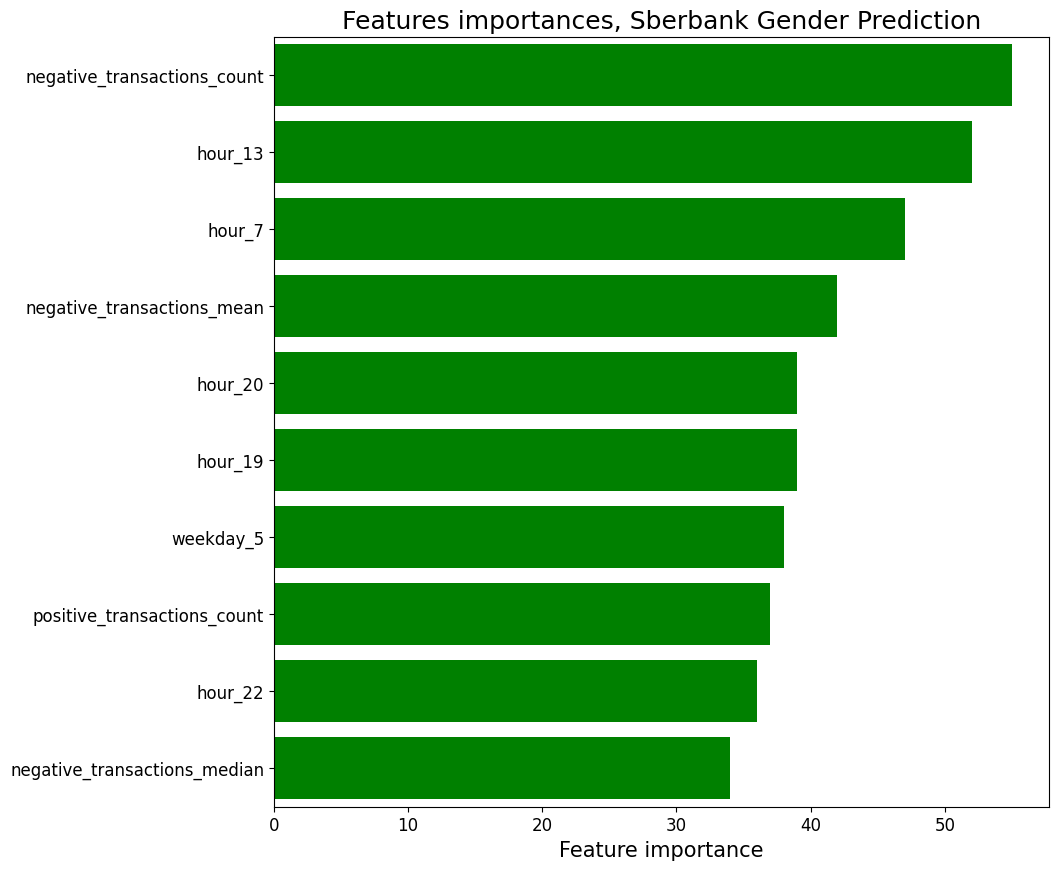

In [16]:
target = data_train.join(gender_train, how='inner')['gender']
cv_score(params, data_train, target)
### Число деревьев для XGBoost имеет смысл выставлять по результатам на кросс-валидации 
clf, submission = fit_predict(params, 180, data_train, data_test, target)
draw_feature_importances(clf, 10)
# В итоге можем отправить полученное решение на платформу Kaggle. 
# Для этого выгрузим его в *.csv - файл, после чего полученный файл можем загружать в качестве ответа.
#submission.to_csv('./data/submission.csv')

In [7]:
params = {
    'eta': 0.1,
    'max_depth': 10,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    
    'gamma': 0.9,
    'lambda': 0.5,
    'alpha': 0.2,
    'min_child_weight': 0.2,
    
    'eval_metric': 'auc',
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'njobs': -1,
    'tree_method': 'approx'
}
target = data_train.join(gender_train, how='inner')['gender']
cv_score(params, data_train, target)

Cross-validation, ROC AUC: 0.667+-0.009
Trees: 42


In [71]:
params = {
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    
    'gamma': 0.5,
    'lambda': 0,
    'alpha': 2,
    'min_child_weight': 1,
    
    'eval_metric': 'auc',
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'njobs': -1,
    'tree_method': 'approx'
}
target = data_train.join(gender_train, how='inner')['gender']
cv_score(params, data_train, target)

Cross-validation, ROC AUC: 0.681+-0.008
Trees: 81


In [50]:
params = {
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    
    'gamma': 0.1,
    'lambda': 1,
    'alpha': 3,
    'min_child_weight': 0,
    
    'eval_metric': 'auc',
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'njobs': -1,
    'tree_method': 'approx'
}
target = data_train.join(gender_train, how='inner')['gender']
cv_score(params, data_train, target)

Cross-validation, ROC AUC: 0.683+-0.008
Trees: 99


## Ищем дни

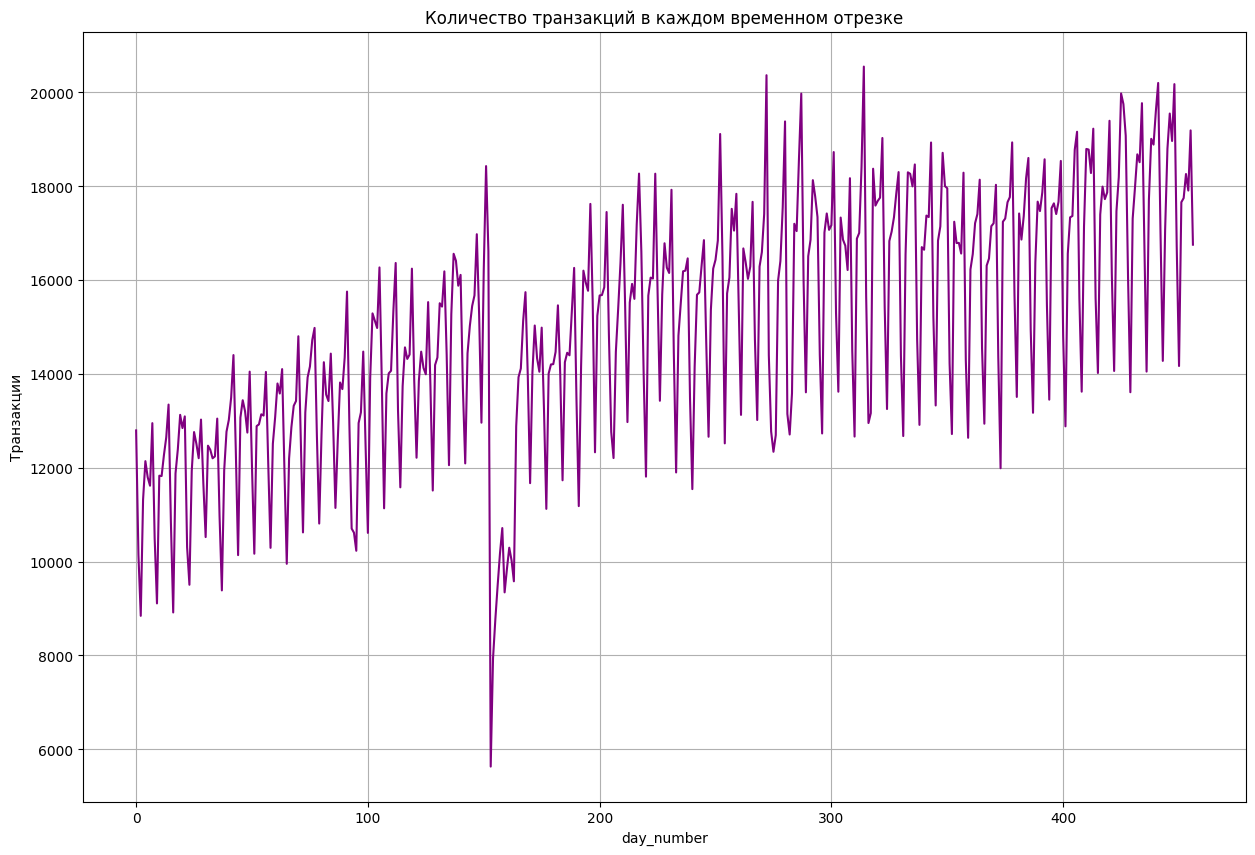

In [33]:
data = transactions

# Разделяем строку по пробелу и создаем новый столбец 'day_number'
data['day_number'] = data['tr_datetime'].str.split(' ', expand=True)[0]

# Преобразуем 'day_number' в числовой формат
data['day_number'] = data['day_number'].astype(int)

# Группируем данные по 'day_number' и считаем количество транзакций
transaction_counts = data.groupby('day_number').size()

# Строим график
plt.figure(figsize=(15, 10))
plt.plot(transaction_counts.index, transaction_counts.values, marker=None, linestyle='-', color='purple')
plt.title('Количество транзакций в каждом временном отрезке')
plt.xlabel('day_number')
plt.ylabel('Транзакции')
plt.grid(True)
plt.show()

# Новый год

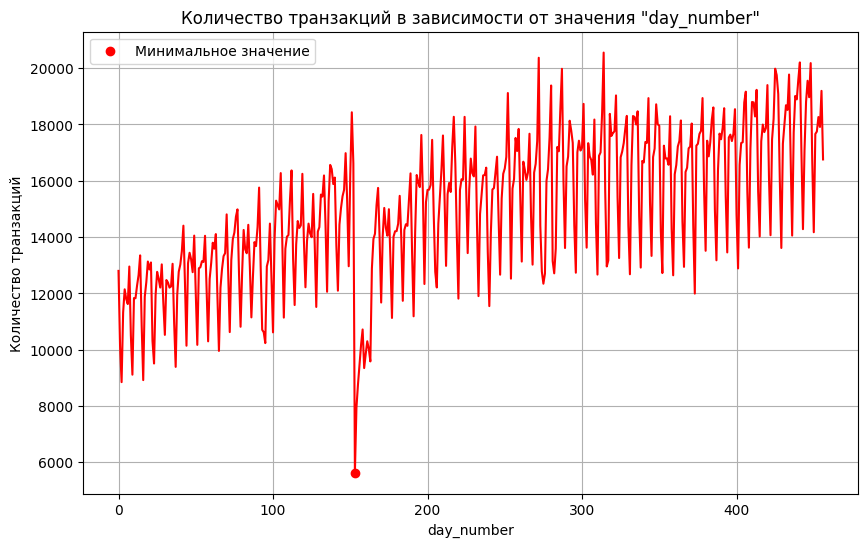

День с самым маленьким числом транзакций: 153


In [34]:
import matplotlib.pyplot as plt

# Используем более описательные имена для переменных
data = transactions

# Разделяем строку по пробелу и создаем новый столбец 'day_number'
data['day_number'] = data['tr_datetime'].str.split(' ', expand=True)[0]

# Преобразуем 'day_number' в числовой формат
data['day_number'] = data['day_number'].astype(int)

# Группируем данные по 'day_number' и считаем количество транзакций
transaction_counts = data.groupby('day_number').size()

# Находим день с самым маленьким числом транзакций
min_transaction_day = transaction_counts.idxmin()

# Строим график
plt.figure(figsize=(10, 6))
plt.plot(transaction_counts.index, transaction_counts.values, marker=None, linestyle='-', color='r')
plt.scatter(min_transaction_day, transaction_counts[min_transaction_day], color='r', label='Минимальное значение')
plt.title('Количество транзакций в зависимости от значения "day_number"')
plt.xlabel('day_number')
plt.ylabel('Количество транзакций')
plt.legend()
plt.grid(True)
plt.show()

print(f"День с самым маленьким числом транзакций: {min_transaction_day}")



Пусть теперь 153 номер - 1 января. Теперь я найду 8 марта и сравнью временную разницу между ними, и, если она совпадет с реальной, значит я угадал. 

In [35]:
from datetime import datetime

# Задаем даты
start_date = datetime(2023, 1, 1)
end_date = datetime(2023, 3, 8)

# Вычисляем разницу в днях
days_difference = (end_date - start_date).days

print(f"Между 1 января и 8 марта прошло {days_difference} дней.")



Между 1 января и 8 марта прошло 66 дней.


или 67 дней если год весокосный

# Цветы!

5992 - Код транзакции Флористики

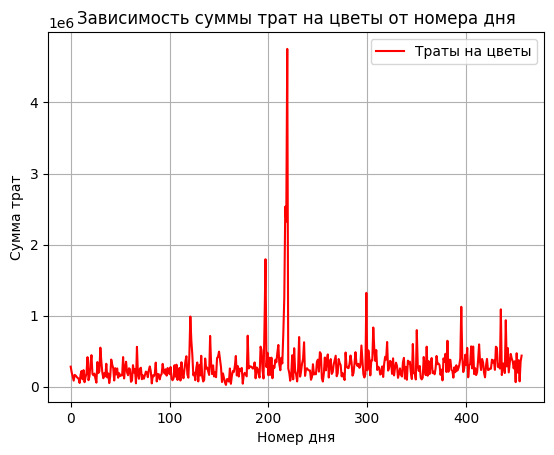

День с самой большой тратой на цветы: 219


In [40]:
df = transactions

# Фильтруем транзакции с mcc_code, равным 5992, и отрицательными суммами
filtered_transactions = df[(df['mcc_code'] == 5992) & (df['amount'] < 0)]

# Создаем новый DataFrame с 'day_number' и суммой отрицательных сумм
flower_expenses = filtered_transactions.groupby('day_number')['amount'].sum()

# Преобразуем отрицательные суммы в положительные
flower_expenses = flower_expenses.abs()

plt.plot(flower_expenses.index, flower_expenses.values, label='Траты на цветы', linestyle='-', color='r')

plt.title('Зависимость суммы трат на цветы от номера дня')
plt.xlabel('Номер дня')
plt.ylabel('Сумма трат')
plt.legend()
plt.grid(True)
plt.show()

# Находим день с самой большой тратой на цветы
max_expense_day = flower_expenses.idxmax()

print(f"День с самой большой тратой на цветы: {max_expense_day}")



219 - 153 = 66 это значит что я нашел те самые даты и теперь можно восстановить все числа. Но нас интересует только начало отсчета, т.е. 0 день. Это будет 1 августа.

# День недели

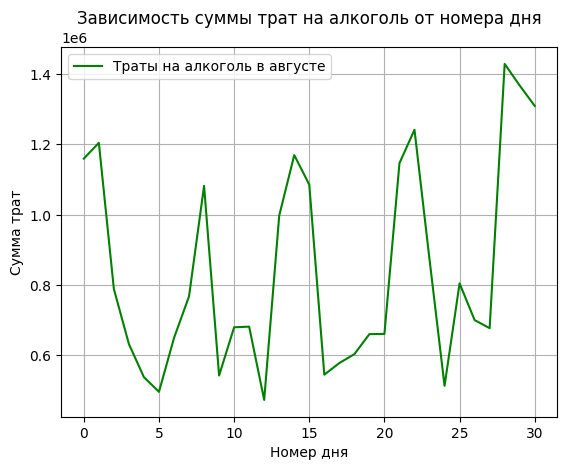

День с самой большой тратой на алкоголь: 28


In [41]:
df = transactions

# Фильтруем транзакции с mcc_code, равным 5921, и отрицательными суммами
filtered_transactions = df[(df['mcc_code'] == 5921) & (df['amount'] < 0)]

# Создаем новый DataFrame с 'day_number' и суммой отрицательных сумм
alco_expenses = filtered_transactions.groupby('day_number')['amount'].sum()

# Преобразуем отрицательные суммы в положительные
alco_expenses = alco_expenses.abs()

alco_expenses = alco_expenses.head(31)

plt.plot(alco_expenses.index, alco_expenses.values, label='Траты на алкоголь в августе', linestyle='-', color='green')

plt.title('Зависимость суммы трат на алкоголь от номера дня')
plt.xlabel('Номер дня')
plt.ylabel('Сумма трат')
plt.legend()
plt.grid(True)
plt.show()

# Находим день с самой большой тратой на алкоголь
max_expense_day = alco_expenses.idxmax()

print(f"День с самой большой тратой на алкоголь: {max_expense_day}")

In [42]:
fridays = alco_expenses[alco_expenses > 1100000].index

print("Предположительные пятницы:", fridays)

Предположительные пятницы: Index([0, 1, 14, 21, 22, 28, 29, 30], dtype='int64', name='day_number')


Видно, что скорее всего 14 августа - пятница, 21 и 22 августа - пятница и суббота. А значит 1 августа тоже пятница.

1 августа пятница была только в 2008 и 2014 годах. Но так как я знаю что 2008 год был весокосным, а у нас между 1 января и 8 марта 66 дней, а не 67, значит все таки это 1 августа 2014 года пятница.

# Декодировать суммы поступлений и списаний.

In [43]:
filtered_amounts = df[(df['tr_type'] == 2010) & (df['amount'] < 0)]['amount']
unique_amounts = filtered_amounts.unique()
sorted_unique_amounts = pd.Series(unique_amounts).astype(float).sort_values()

differences = sorted_unique_amounts.diff()

print(differences)
differences_counts = differences.value_counts()

top_10_differences = differences_counts.head(10)
print("Топ-10 самых частых разностей:")
print(top_10_differences)

661          NaN
206     36755.54
566     89836.63
272     22459.15
1207    67377.48
          ...   
0        1122.96
962        94.78
112      1028.18
46       1122.95
21       1122.96
Length: 1332, dtype: float64
Топ-10 самых частых разностей:
2245.92     146
2245.92      85
2245.91      75
2245.91      69
1122.96      68
1122.96      64
4491.83      54
1122.96      39
11229.58     38
2245.91      37
Name: count, dtype: int64


In [47]:
secret_coefficient = differences_counts.idxmax() / 100

print(f'Секретный коэффициент {secret_coefficient}')

Секретный коэффициент 22.459199999999257


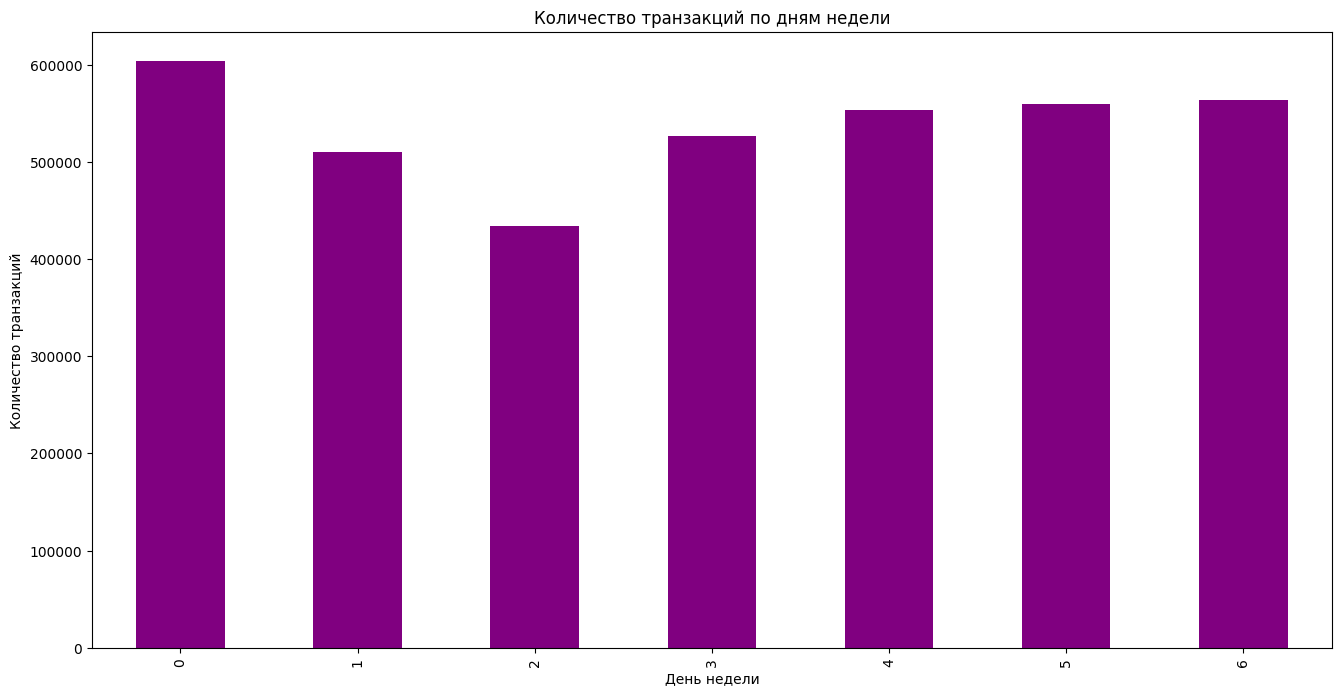

In [48]:
plt.figure(figsize=(16, 8))
transactions_train['weekday'].value_counts().sort_index().plot(kind='bar', color='purple')
plt.title('Количество транзакций по дням недели')
plt.xlabel('День недели')
plt.ylabel('Количество транзакций')
plt.show()

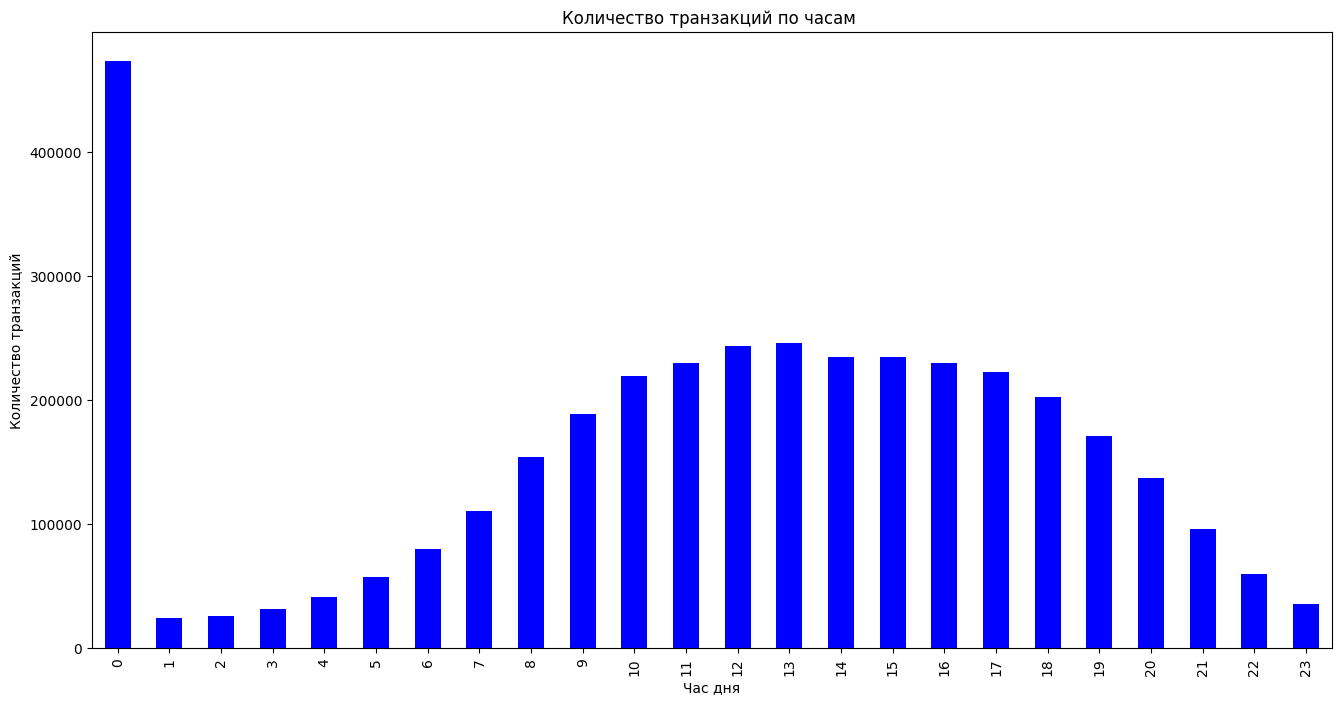

In [49]:
plt.figure(figsize=(16, 8))
transactions_train['hour'].value_counts().sort_index().plot(kind='bar', color='blue')
plt.title('Количество транзакций по часам ')
plt.xlabel('Час дня')
plt.ylabel('Количество транзакций')
plt.show()